In [1]:
# 
# Encoder implementation
# Decoder from library
# Results
# Formatting code
# Test cases
# Report

import qsharp
from collections import deque
from typing import List
from decoder import GraphDecoder
import numpy as np

# StabilizerMap: Holds the information related to the stabilizers present 
# in the logical qubit and defines operations to maintain mapping between
# measure qubits, its coordinates and relation with data qubits

class StabilizerMap:
    '''
    Position of stabilizer on the lattice matters, this map keeps 
    mapping of local qubits to the global order on the surface
    '''

    def __init__(self, d, xMaps, zMaps, order):
        self.d = d
        self.zMaps = zMaps
        self.xMaps = xMaps
        self.order = order
        self.orderedMappings = []
        self.ancillaMappings = {X: {}, Z: {}}
        self.__generateStabilizerMap()
    
    def getByAncillaPosition(self, type, ancillaPosition):
        # Position of stabilizer measured ancilla to order on surface code lattice
        orderedPosition = self.ancillaMappings[type][ancillaPosition]
        return self.orderedMappings[orderedPosition]

    def __generateStabilizerMap(self):
        # Map: index is position, value is dict - {"type": X|Z, "coordinates": (x,y)}
        xqueue = deque(self.stabilizerCoordinates(self.xMaps))
        zqueue = deque(self.stabilizerCoordinates(self.zMaps))
        zi = 0
        xi = 0
        for position in range(len(self.order)):
            self.orderedMappings.append({
                "type": self.order[position],
                "coordinates": (
                    zqueue if self.order[position] == Z else xqueue
                ).popleft()
            })
            if self.order[position] == Z:
                self.ancillaMappings[Z][zi] = position
                zi += 1
            else:
                self.ancillaMappings[X][xi] = position
                xi += 1
    
    def _correctCoordinate(self, coordinate):
        # Boundary stabilizers should be corrected to space away from data qubits which lie on 0 or d axis
        if coordinate == 0:
            return coordinate-0.5
        if coordinate == (self.d-1):
            return coordinate + 0.5
        return coordinate

    def stabilizerCoordinates(self, stabilizerMap):
        syndromeMap = []
        for i,neighbourQubits in enumerate(stabilizerMap):
            qubits = []
            for qubit in neighbourQubits:
                qubits.append((qubit//self.d, qubit%self.d))
            x = sum(q[0] for q in qubits)/len(qubits)
            y = sum(q[1] for q in qubits)/len(qubits)

            syndromeMap.append((self._correctCoordinate(x), self._correctCoordinate(y)))
        return syndromeMap


X = "X"
Z = "Z"




## Pauli Tracker
Tracks the list of measures and syndrome
in the logical qubit, effective to identify the errors to perform error correction through detection events that signal possibilities of errors

<img src="timeline.png"/>
<br/>
The below class tracks the error in timeline as shown in the above image.

In [2]:
# PauliTracker: Tracks the list of measures and syndrome across timesteps in 3D space
class PauliTracker:
    '''Tracks the Pauli X&Z stabilizers measurements, Record 
    the stabilizer measurement outcomes in each round without
    physically correcting the qubits'''

    def __init__(self):
        self.tracker = {X: [], Z: []}
        self.order = []

    def getChanges(self, type, currentMeasures):
        '''Get parity of previous stabilizer measures v/s current to detect event of error'''
        if not self.tracker[type]:
            return currentMeasures
        return [1 if a==b else 0 for a,b in zip(self.tracker[type][-1], currentMeasures)]


    def track(self, xMeasures, zMeasures):
        xMeasures = LogicalQubit.convertResultToBinaryArray(xMeasures)
        zMeasures = LogicalQubit.convertResultToBinaryArray(zMeasures)
    
        self.tracker[X].append(self.getChanges(X, xMeasures))
        self.tracker[Z].append(self.getChanges(Z, zMeasures))
    
    def getX(self):
        return self.tracker[X]
    def getZ(self):
        return self.tracker[Z]
    def setOrder(self, order):
        self.order = order
    
    def getTrackedErrors(self, stabilizerMap: StabilizerMap):
        '''Get difference in each timestep errors of X and Z stabilizers'''
        X_ERRORS = []
        Z_ERRORS = []
        for error in self.tracker:
            for timestep in range(len(self.tracker[error])):
                for stabilizerIndex in range(len(self.tracker[error][timestep])):
                    if self.tracker[error][timestep][stabilizerIndex]:
                        stabilizer = stabilizerMap.getByAncillaPosition(error, stabilizerIndex)
                        bucket = X_ERRORS if error == X else Z_ERRORS
                        bucket.append((timestep, stabilizer["coordinates"][0], stabilizer["coordinates"][1]))
        return X_ERRORS, Z_ERRORS



In [3]:
# **Logical Qubit**: Complete implementation of the logical qubit
# Implements rotated surface code through QSharp by first encodes the logical qubit by 
# generating a map of lattice with stabilizers, uses the map to construct the lattice with stabilizers,
# then decodes the errors using syndromes tracked by PauliTracker & MWPM algorithm to correct 
# errors on data qubits. Finally, measures data qubit to check the true logical state.
class LogicalQubit:
    def __init__(self, d, T):
        self.d: int = d
        self.timesteps: int = T
        self.PAULI_TRACKER = PauliTracker()
        self.decoder: GraphDecoder = GraphDecoder(d, T)
        self.stabilizerMap: StabilizerMap = None
        self.TOTAL_DATA_QUBITS = self.d**2
    
    @staticmethod
    def convertResultToBinaryArray(result: List[qsharp.Result]):
        return [1 if bit == qsharp.Result.One else 0 for bit in result]
    
    def getDataQubitCoordinates(self, i, j):
        return (i*self.d) + j


    def runRound(self):
        xSyndrome, zSyndrome = qsharp.eval(f"RotatedSurfaceCode.Round(TOTAL_DATA_QUBITS, qubits, xMaps, zMaps, order);")
        self.PAULI_TRACKER.track(xSyndrome, zSyndrome)

        

    def encode(self, xnoise: float, znoise: float):
        
        qsharp.init(project_root=".")
        qsharp.eval(f"import Std.Diagnostics.ConfigurePauliNoise;")
        qsharp.eval(f"import Std.Arrays.ForEach;")
        qsharp.eval(f"let d = {self.d};")
        qsharp.eval(f"let TOTAL_DATA_QUBITS = {self.TOTAL_DATA_QUBITS};")
        qsharp.eval("use qubits = Qubit[TOTAL_DATA_QUBITS];")
        qsharp.eval("ApplyToEach(X, qubits);")
        qsharp.eval(f"ConfigurePauliNoise({xnoise}, 0.0, {znoise});")
        qsharp.eval("ResetAll(qubits);")
        
        xMaps, zMaps, order = qsharp.eval(f"RotatedSurfaceCode.GetMaps(d);")
        self.stabilizerMap = StabilizerMap(self.d, xMaps, zMaps, order)
        qsharp.eval(f"let (xMaps, zMaps, order) = RotatedSurfaceCode.GetMaps(d);")

        self.runRound()
        for t in range(self.timesteps-1):
            self.runRound()

    def __searchOperator(self, operations:dict, query):
        for k,v in operations.items():
            if np.array_equal(v, query):
                return k

    def decode(self, xnoise: float, znoise: float):
        flips = {}
        X_ERRORS, Z_ERRORS = self.PAULI_TRACKER.getTrackedErrors(self.stabilizerMap)

        for error_key,errors in dict(zip((X,Z), (X_ERRORS,Z_ERRORS))).items():
            if errors:
                error_graph, paths = self.decoder.make_error_graph(errors, error_key, xnoise+znoise)
                matching_graph = self.decoder.matching_graph(error_graph,error_key)
                matches = self.decoder.matching(matching_graph,error_key)
                flips[error_key] = self.decoder.calculate_qubit_flips(matches, paths,error_key)
            else:
                flips[error_key] = {}
        decodedResults, operatorMap = self.decoder.net_qubit_flips(flips["X"], flips["Z"], decompose=True)

        for position, operation in decodedResults.items():
            # operator = self.__searchOperator(operatorMap, operation)
            corruptQubit = self.getDataQubitCoordinates(int(position[0]), int(position[1]))
            correction = f"RotatedSurfaceCode.CorrectDataQubit(qubits[{corruptQubit}], {operation[0]}, {operation[1]}, {operation[2]});"
            # print("Applying:",correction)
            qsharp.eval(correction)

    def getState(self):
        all = qsharp.eval("RotatedSurfaceCode.MeasureLogicalZ(d, qubits);")
        topdown = qsharp.eval("RotatedSurfaceCode.MeasureLogicalZTopDown(d, qubits);")
        antidiagonal = qsharp.eval("RotatedSurfaceCode.MeasureLogicalZAntiDiagonal(d, qubits);")
        lastrow = qsharp.eval("RotatedSurfaceCode.MeasureLogicalZLastRow(d, qubits);")
        qsharp.eval("ResetAll(qubits);")
        return all, topdown, antidiagonal, lastrow
        
        
  

#### Experiment showing that measuring along diagonal is effective
<img style="margin:auto;" src="rotated_surface_code_measures.png" width="20%">
<br/>
<br/>

- The image shows that the orginal lattice is rotated to save the number of qubits used.
- This causes the logical qubits positions spacially which also changes the measurement direction.
- As shown above XL Logical operation of X is defined by applying X operation or measuring it on the anti-diagonal qubits.
<br/>
<br/>
The following snippet experimentally proves that we should that measuring along the anti-diagonal data qubits is effective.

In [8]:
d = 3
noise = 0.1
T = 1
import networkx as nx

true_state = qsharp.Result.Zero

# Warm up for experiment
for i in range(10):
  qubit = LogicalQubit(d, T)
  qubit.encode(noise//2, noise//2)
  qubit.decode(noise//2, noise//2)
  state = qubit.getState()

maps = ["Parity of all data qubits", "Parity of top to down", "Parity of qubits in anti-diagonal", "Parity of qubits along the last row of lattice"]
votes = {}
for round in range(10):
  successResults = [[], [], [], []]
  print(f"Round {round}:")
  for i in range(100):
    qubit = LogicalQubit(d, T)
    qubit.encode(noise//2, noise//2)
    qubit.decode(noise//2, noise//2)
    state = qubit.getState()
    for i,s in enumerate(state):
      successResults[i].append(1 if s == qsharp.Result.Zero else 0)
  winner = 0
  winpos = 0
  for i,r in enumerate(successResults):
    successRate = sum(r)/100
    print(f"Success Rate {i}: {successRate}")
    if max(successRate, winner) == successRate:
      winner = successRate
      winpos = i
  votes[winpos] = votes.get(winpos, 0) + 1
  print("Best in Round:", maps[winpos])
print("Best data qubits for logical measurement in Z basis is ", maps[max(votes, key=votes.get)])

      

  
  
# qubit.decoder.graph_2D(qubit.decoder.S[X],'distance')
# qubit.decoder.graph_2D(qubit.decoder.S[Z],'distance')


Round 0:
Success Rate 0: 0.58
Success Rate 1: 0.39
Success Rate 2: 0.63
Success Rate 3: 0.55
Best in Round: Parity of qubits in anti-diagonal
Round 1:
Success Rate 0: 0.53
Success Rate 1: 0.43
Success Rate 2: 0.69
Success Rate 3: 0.51
Best in Round: Parity of qubits in anti-diagonal
Round 2:
Success Rate 0: 0.54
Success Rate 1: 0.48
Success Rate 2: 0.7
Success Rate 3: 0.52
Best in Round: Parity of qubits in anti-diagonal
Round 3:
Success Rate 0: 0.54
Success Rate 1: 0.59
Success Rate 2: 0.54
Success Rate 3: 0.55
Best in Round: Parity of top to down
Round 4:
Success Rate 0: 0.56
Success Rate 1: 0.45
Success Rate 2: 0.59
Success Rate 3: 0.51
Best in Round: Parity of qubits in anti-diagonal
Round 5:
Success Rate 0: 0.5
Success Rate 1: 0.63
Success Rate 2: 0.65
Success Rate 3: 0.56
Best in Round: Parity of qubits in anti-diagonal
Round 6:
Success Rate 0: 0.58
Success Rate 1: 0.54
Success Rate 2: 0.63
Success Rate 3: 0.45
Best in Round: Parity of qubits in anti-diagonal
Round 7:
Success Rat

### Setup for Noisy simulation experiment

In [6]:
def isLogicalState(state):
    # Anti-Diagonal Measurement
    return qsharp.Result.Zero == state[2]


def run_experiment_for_d(d_values, p_values, num_trials):
    results = {}
    for d in d_values:
        logical_error_rates = []
        print(f"Running for code distance d={d}")
    
        for p in p_values:
            logical_errors = 0
            print(f"Physical error rate p={p:.3f}")
            true_state = qsharp.Result.Zero

            for i in range(num_trials):
                qubit = LogicalQubit(d, d)
                qubit.encode(p//2, p//2)
                qubit.decode(p//2, p//2)
                state = qubit.getState()
                logical_errors += int(not isLogicalState(state))
            logical_error_rates.append(logical_errors / num_trials)

        results[d] = logical_error_rates

    return results
# physical_error_values = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4]
physical_error_values = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64]

TRAILS = 100
logical_errors = run_experiment_for_d(d_values=[3], p_values=physical_error_values, num_trials=TRAILS)

Running for code distance d=3
Physical error rate p=0.010
Physical error rate p=0.020
Physical error rate p=0.040
Physical error rate p=0.080
Physical error rate p=0.160
Physical error rate p=0.320
Physical error rate p=0.640


### Physical v/s Logical Noise

{3: [0.03, 0.08, 0.04, 0.05, 0.06, 0.04, 0.04]}


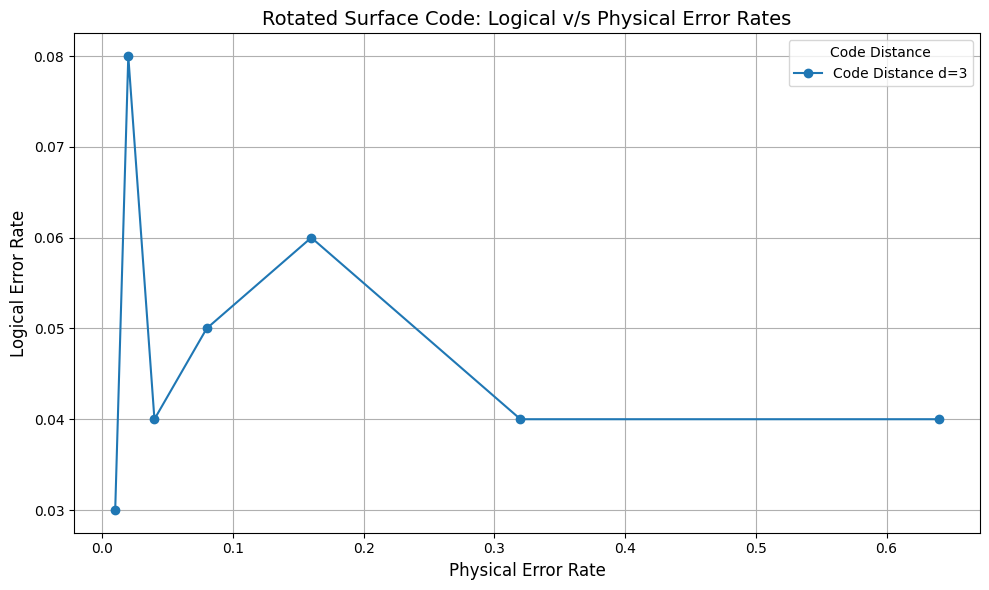

In [7]:
import matplotlib.pyplot as plt

print(logical_errors)
plt.figure(figsize=(10, 6))
for d, errors in logical_errors.items():
    plt.plot(physical_error_values, errors, marker='o', label=f'Code Distance d={d}')

# Labels and title
plt.xlabel('Physical Error Rate', fontsize=12)
plt.ylabel('Logical Error Rate', fontsize=12)
plt.title('Rotated Surface Code: Logical v/s Physical Error Rates', fontsize=14)
plt.legend(title='Code Distance')
plt.grid(True)
plt.tight_layout()

# Save and show
plt.savefig('logical_vs_physical_error_rates.png', dpi=300)
plt.show()

- The varying d values are not simulated due to the resource constraint of the machine as d=5 requires 49 qubits in total including ancillas
- We expect the logical error rate to decrease with increase in physical error rate.
- As we can see that the error distance decreases with increase in showing that the logical qubit is resilient to errors. 

### Results of comparing with increase in Timesteps T
- The commonly used T values are d or d**d to know the relationship we simulate an experiment for varying timesteps
- The previous expereiment was run with T=3, 3 timesteps same as distance code, now we run varying time steps keeping the distance code (d) and physical error rate (p) as constant. 

In [7]:
def isLogicalState(state):
    # Anti-Diagonal Measurement
    return qsharp.Result.Zero == state[2]



def run_experiment_for_T(tValues, pValues):
    SHOTS = 100
    results = {}
    for t in tValues:
        logical_error_rates = []
        print(f"Running for code distance d=3, timesteps t={t}")
    
        for p in pValues:
            logical_errors = 0
            print(f"Physical error rate p={p:.3f}")

            for i in range(SHOTS):
                qubit = LogicalQubit(3, t)
                qubit.encode(p//2, p//2)
                qubit.decode(p//2, p//2)
                state = qubit.getState()
                logical_errors += int(not isLogicalState(state))
            logical_error_rates.append(logical_errors / SHOTS)

        results[t] = logical_error_rates

    return results

physical_error_values = [0.001, 0.01, 0.1, 0.15, 0.2, 0.3, 0.4]
logical_errors = run_experiment_for_T(tValues=[1,2,3,9,12], pValues=physical_error_values)

Running for code distance d=3, timesteps t=1
Physical error rate p=0.001
Physical error rate p=0.010
Physical error rate p=0.100
Physical error rate p=0.150
Physical error rate p=0.200
Physical error rate p=0.300
Physical error rate p=0.400
Running for code distance d=3, timesteps t=2
Physical error rate p=0.001
Physical error rate p=0.010
Physical error rate p=0.100
Physical error rate p=0.150
Physical error rate p=0.200
Physical error rate p=0.300
Physical error rate p=0.400
Running for code distance d=3, timesteps t=3
Physical error rate p=0.001
Physical error rate p=0.010
Physical error rate p=0.100
Physical error rate p=0.150
Physical error rate p=0.200
Physical error rate p=0.300
Physical error rate p=0.400
Running for code distance d=3, timesteps t=9
Physical error rate p=0.001
Physical error rate p=0.010
Physical error rate p=0.100
Physical error rate p=0.150
Physical error rate p=0.200
Physical error rate p=0.300
Physical error rate p=0.400
Running for code distance d=3, times

{1: [0.41, 0.36, 0.34, 0.35, 0.46, 0.39, 0.38], 2: [0.36, 0.43, 0.48, 0.5, 0.4, 0.44, 0.38], 3: [0.05, 0.04, 0.09, 0.02, 0.04, 0.12, 0.11], 9: [0.37, 0.42, 0.36, 0.5, 0.42, 0.34, 0.4], 12: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


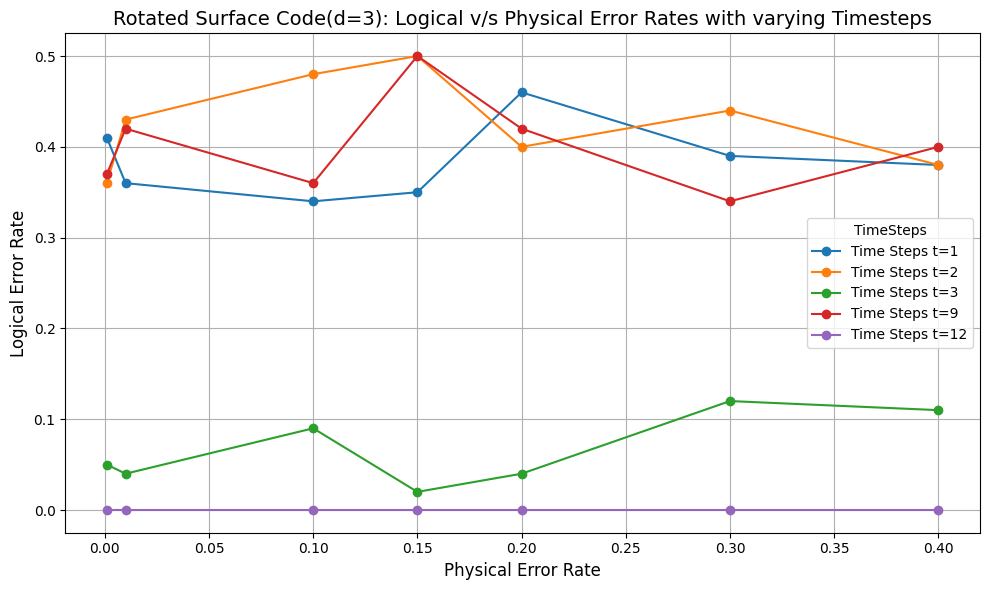

In [8]:
import matplotlib.pyplot as plt

print(logical_errors)
plt.figure(figsize=(10, 6))
for t, errors in logical_errors.items():
    plt.plot(physical_error_values, errors, marker='o', label=f'Time Steps t={t}')

# Labels and title
plt.xlabel('Physical Error Rate', fontsize=12)
plt.ylabel('Logical Error Rate', fontsize=12)
plt.title('Rotated Surface Code(d=3): Logical v/s Physical Error Rates with varying Timesteps', fontsize=14)
plt.legend(title='TimeSteps')
plt.grid(True)
plt.tight_layout()

# Save and show
plt.savefig('logical_vs_physical_timesteps.png', dpi=300)
plt.show()

- The logical errors tend to decrease with increase in timesteps.
- The correction is better for values with t=(d>3), except for t=9 where it seems to have higher error rate.

### Visualization of matching graphs for error correction

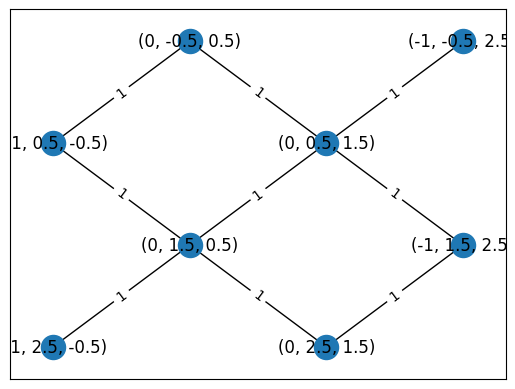

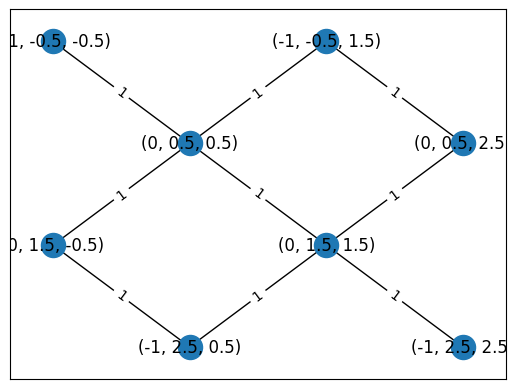

In [13]:
p = 0.1
qubit = LogicalQubit(d=3, T=1)
qubit.encode(p//2, p//2)
qubit.decode(p//2, p//2)
qubit.decoder.graph_2D(qubit.decoder.S[X], "distance")
qubit.decoder.graph_2D(qubit.decoder.S[Z], "distance")


- The graphs shows the surfaces of stabilizer surfaces in 2D plane and their connection marking an event of detection. - The coordinates of the stabilizers are all factors of 0.5 as the data qubits lie between them.
- We use this matching graphs mapping the error detection zones to affected qubits to identify and correct errors
- The coordinates with -1 are virtual qubits which do not exits and are added to connect the boundaries for matching a concept of torus code


In [4]:
p = 0.1
qubit = LogicalQubit(d=3, T=5)
qubit.encode(p//2, p//2)
qubit.decode(p//2, p//2)

qubit.decoder.graph_3D(qubit.decoder.S[X], "distance")
# plt.show()
# qubit.decoder.graph_3D(qubit.decoder.S[Z], "distance")

<Figure size 2000x1400 with 0 Axes>

### Conclusion:
- Successfully implemented a logical qubit using the surface code in Q#.

- Applied Minimum-Weight Perfect Matching (MWPM) to correct quantum errors effectively.

- Visualized error syndromes, aiding in understanding and debugging the error correction process.

- Conducted a comparative analysis of logical qubit measurement outcomes to assess correction performance.

- Simulated error correction across varying error rates, demonstrating the robustness and limitations of the surface code under different noise conditions.




### References: 
https://www.nature.com/articles/s41586-022-05434-1 - d=3 Implementation <br/>
https://www.nature.com/articles/s41586-022-04566-8 - More on implementation <br/>
https://arxiv.org/html/2307.14989v4/#S5.F7 - Diagrams <br/>
https://arxiv.org/pdf/2409.14765 Core Rotated circuit comparision <br/>